In [9]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import SFNO, FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


In [10]:
model = FNO(n_modes=(32, 32),
             in_channels=3,
             out_channels=3,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense'
           )
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4469859 parameters.


In [11]:
optimizer = AdamW(model.parameters(),
                                lr=8e-4,
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [12]:
l2loss = LpLoss(d=2, p=2, reduction='sum')

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 200 samples
Testing on [50, 50] samples         on resolutions [(32, 64), (64, 128)].
Raw outputs of shape torch.Size([4, 3, 32, 64])
[0] time=7.45, avg_loss=2.6903, train_err=10.7613
Eval: (32, 64)_l2=2.2104, (64, 128)_l2=2.3463


KeyboardInterrupt: 

In [19]:
for _idx, batch in enumerate(test_loaders[(32, 64)]):
    print(batch['y'].shape)
    break

torch.Size([10, 3, 32, 64])


In [16]:
test_loaders

{(32, 64): <torch.utils.data.dataloader.DataLoader at 0x7f301daf6650>,
 (64, 128): <torch.utils.data.dataloader.DataLoader at 0x7f301daf6200>}

# Navier Stokes Training

https://github.com/neuraloperator/neuraloperator/blob/main/scripts/train_navier_stokes.py

In [25]:
from neuralop.data.datasets.navier_stokes import load_navier_stokes_pt
from neuralop.utils import get_project_root
root_dir = get_project_root() / 'neuralop/data/datasets/data'
# Loading the Navier-Stokes dataset in 128x128 resolution
train_loader, test_loaders, data_processor = load_navier_stokes_pt(
    data_root=root_dir,
    train_resolution=128,#config.data.train_resolution,
    n_train=100,
    batch_size=16,
    test_resolutions=[128],
    n_tests=[32],
    test_batch_sizes=[16],
    #encode_input=config.data.encode_input,
    #encode_output=config.data.encode_output,
)

Loading test db for resolution 128 with 32 samples 


In [28]:
for _idx, batch in enumerate(test_loaders[128]):
    print(batch['x'].shape)
    
    break

torch.Size([16, 1, 128, 128])


0


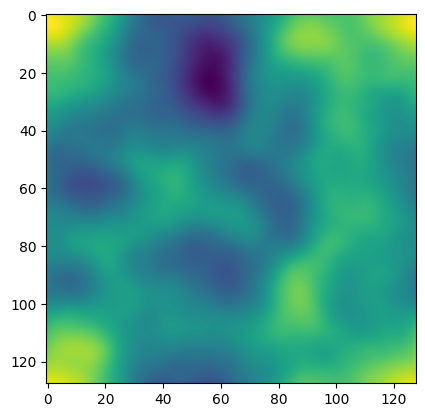

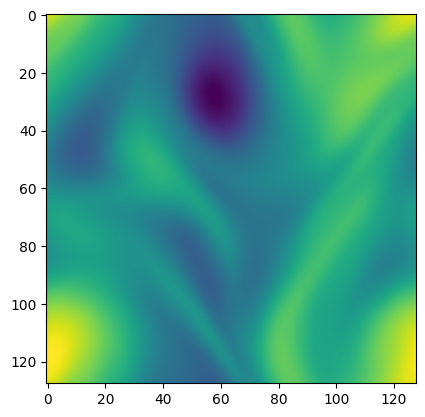

1


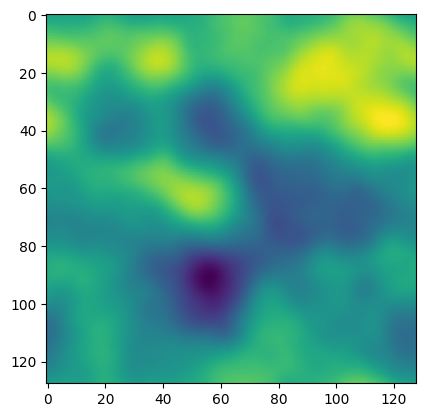

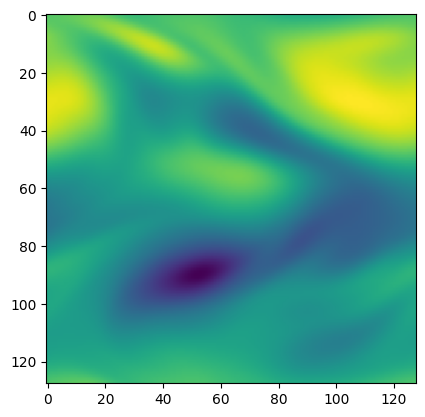

2


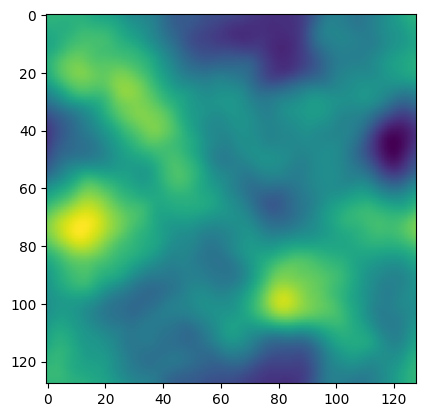

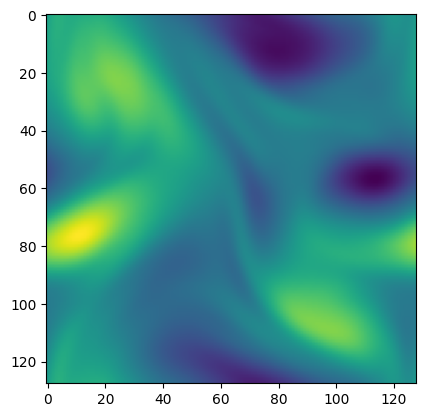

3


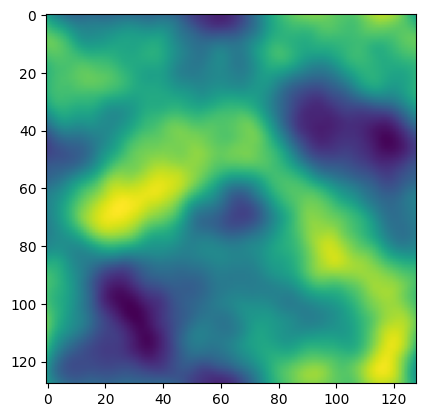

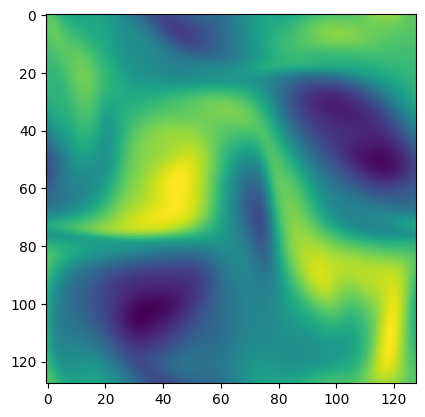

4


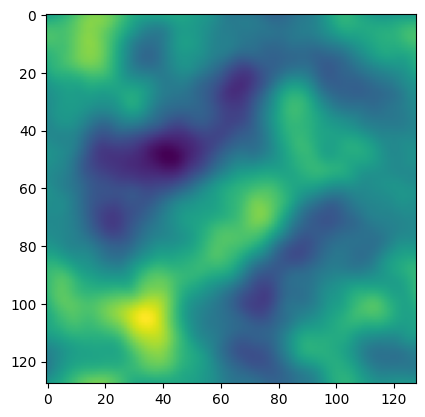

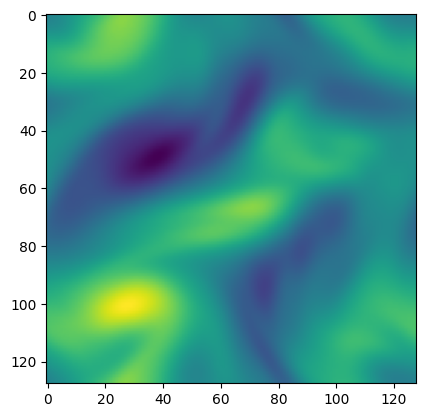

5


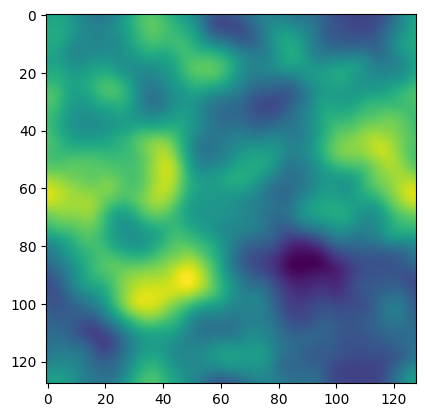

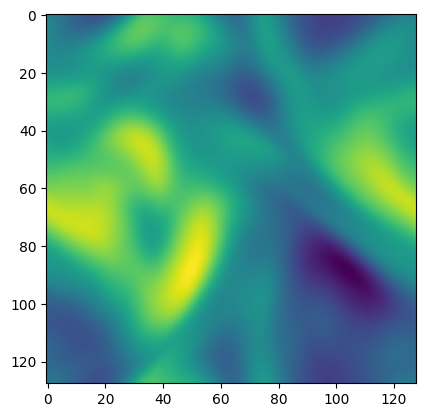

6


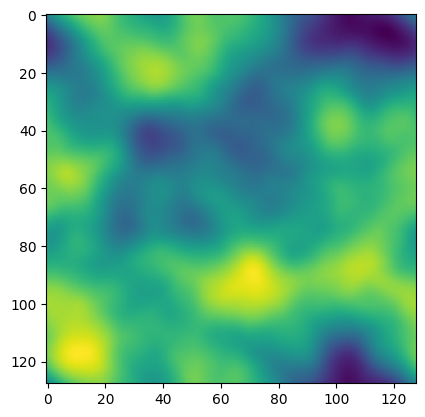

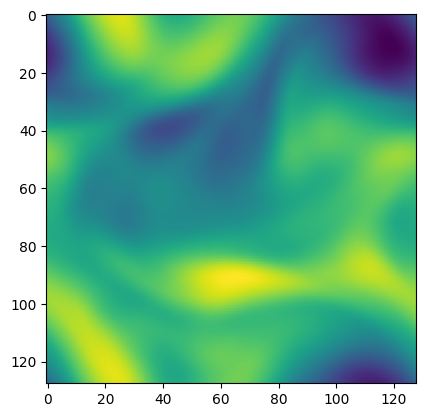

7


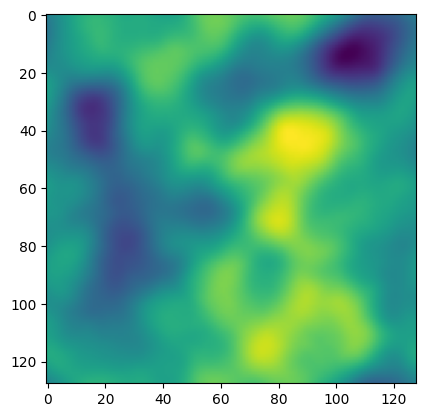

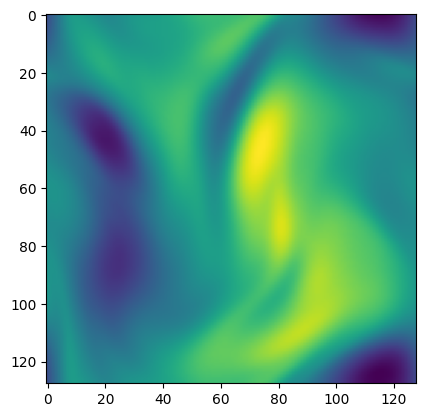

8


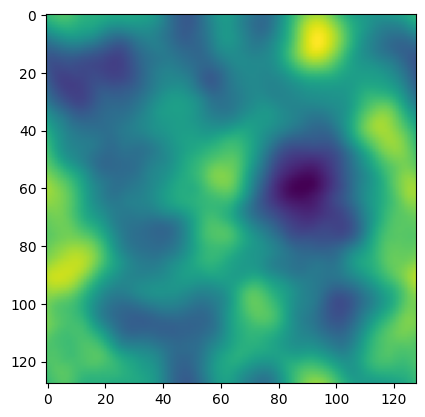

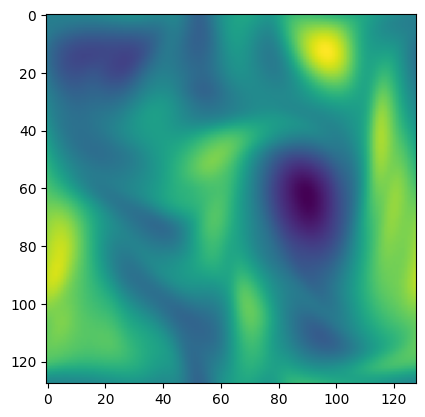

9


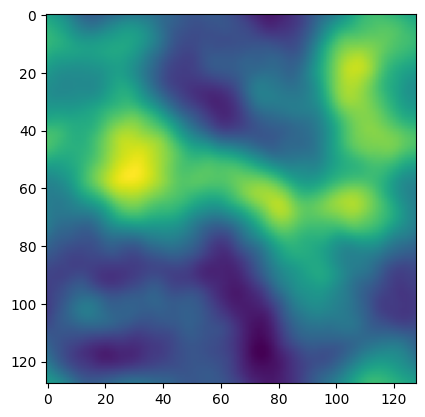

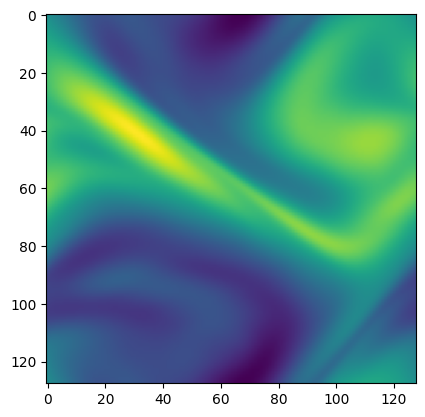

10


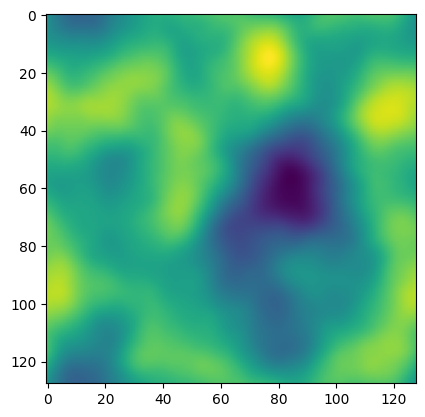

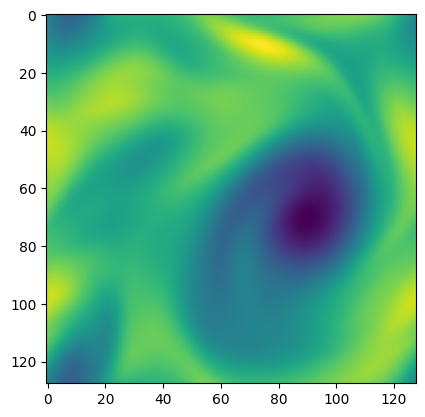

11


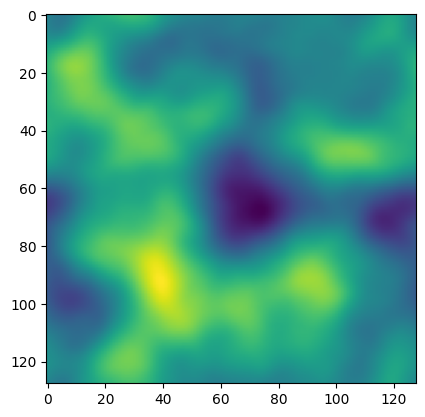

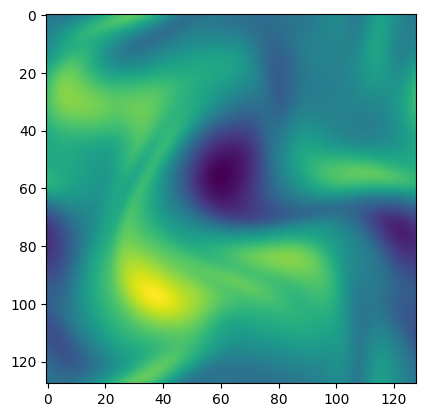

12


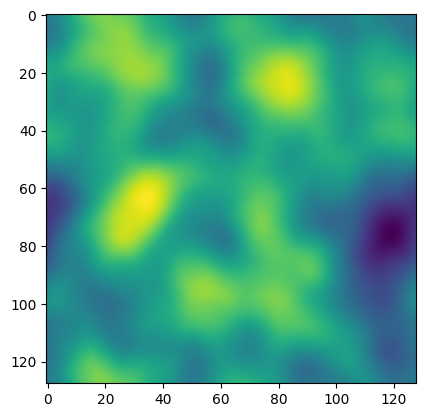

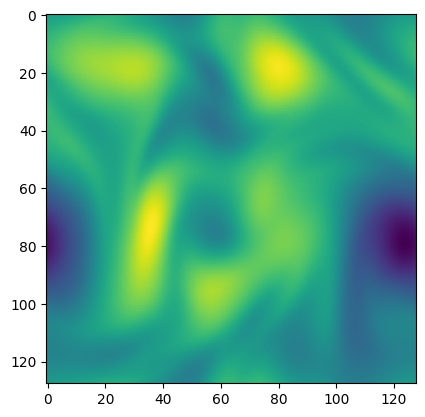

13


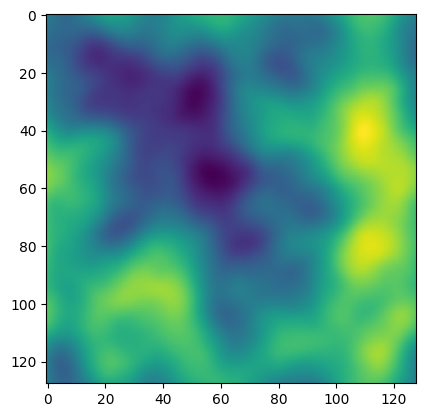

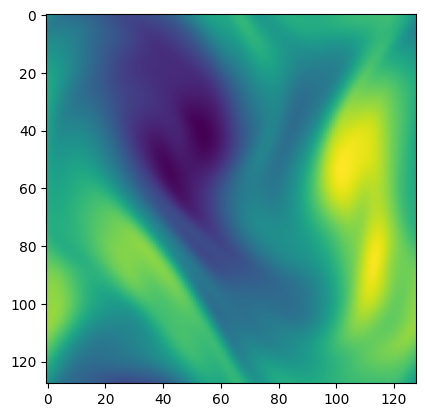

14


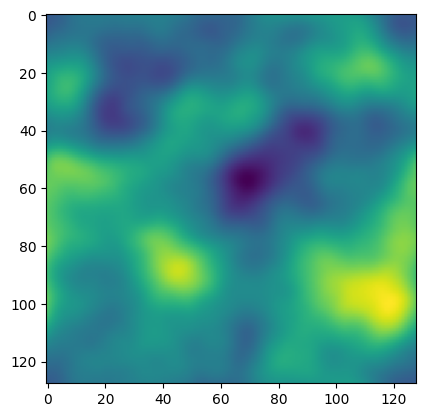

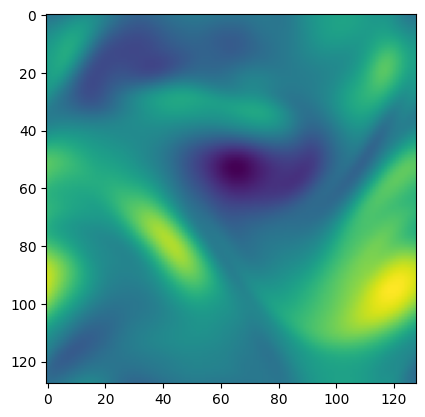

15


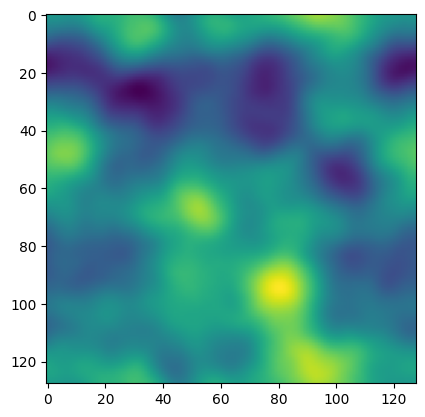

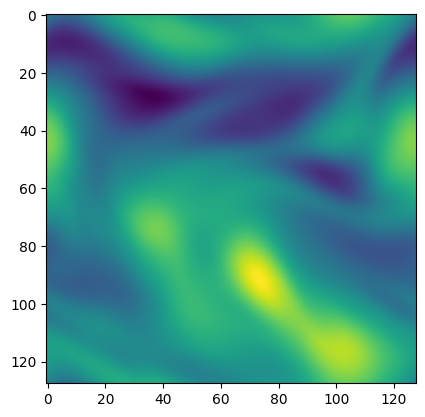

In [42]:
for i in range(16):
    print(i)
    plt.imshow(batch['x'][i, 0, :, :])
    plt.show()
    
    plt.imshow(batch['y'][i, 0, :, :])
    plt.show()

# PINNs Loss

https://github.com/NVIDIA/physicsnemo/blob/main/examples/cfd/darcy_physics_informed/darcy_physics_informed_fno.py 

In [28]:
# https://github.com/neuraloperator/physics_informed/blob/master/download_data.py
import os
import requests
from tqdm import tqdm

_url_dict = {
    'NS-T4000': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/NS_fft_Re500_T4000.npy', 
    'NS-Re500Part0': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/NS_fine_Re500_T128_part0.npy', 
    'NS-Re500Part1': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/NS_fine_Re500_T128_part1.npy', 
    'NS-Re500Part2': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/NS_fine_Re500_T128_part2.npy', 
    'NS-Re100Part0': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/NS_fine_Re100_T128_part0.npy', 
    'burgers': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/burgers_pino.mat', 
    'NS-Re500_T300_id0': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/NS-Re500_T300_id0.npy',
    'NS-Re500_T300_id0-shuffle': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/NS-Re500_T300_id0-shuffle.npy',
    'darcy-train': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/piececonst_r421_N1024_smooth1.mat', 
    'darcy-test': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/piececonst_r421_N1024_smooth2.mat', 
    'cavity': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/cavity.mat',
    'Re500-1_8s-800-pino-140k': 'https://hkzdata.s3.us-west-2.amazonaws.com/PINO/checkpoints/Re500-1_8s-800-PINO-140000.pt',
}


def download_file(url, file_path):
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in tqdm(r.iter_content(chunk_size=256 * 1024 * 1024)):
                f.write(chunk)
    print('Complete')


def main(name, out_dir):
    url = _url_dict[name]
    file_name = url.split('/')[-1]
    os.makedirs(out_dir, exist_ok=True)
    file_path = os.path.join(out_dir, file_name)
    download_file(url, file_path)

out_dir = "pino_data"
for name in _url_dict.keys():
    main(name, out_dir)
!ls pino_data

Start downloading...


1it [00:00, 5940.94it/s]


Complete
Start downloading...


1it [00:00, 7781.64it/s]

Complete
Start downloading...



1it [00:00, 8338.58it/s]


Complete
Start downloading...


1it [00:00, 9118.05it/s]


Complete
Start downloading...


1it [00:00, 9467.95it/s]


Complete
Start downloading...


1it [00:00, 8701.88it/s]


Complete
Start downloading...


1it [00:00, 4396.55it/s]


Complete
Start downloading...


1it [00:00, 6423.13it/s]


Complete
Start downloading...


1it [00:00, 6355.01it/s]


Complete
Start downloading...


1it [00:00, 4346.43it/s]


Complete
Start downloading...


1it [00:00, 8542.37it/s]


Complete
Start downloading...


1it [00:00, 8559.80it/s]


Complete
burgers_pino.mat	      NS_fine_Re500_T128_part2.npy
cavity.mat		      NS-Re500_T300_id0.npy
NS_fft_Re500_T4000.npy	      NS-Re500_T300_id0-shuffle.npy
NS_fine_Re100_T128_part0.npy  piececonst_r421_N1024_smooth1.mat
NS_fine_Re500_T128_part0.npy  piececonst_r421_N1024_smooth2.mat
NS_fine_Re500_T128_part1.npy  Re500-1_8s-800-PINO-140000.pt


In [31]:
!wget https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/piececonst_r421_N1024_smooth1.mat

--2025-06-30 15:11:54--  https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/piececonst_r421_N1024_smooth1.mat
Resolving hkzdata.s3.us-west-2.amazonaws.com (hkzdata.s3.us-west-2.amazonaws.com)... 3.5.85.76, 52.218.176.97, 3.5.83.189, ...
Connecting to hkzdata.s3.us-west-2.amazonaws.com (hkzdata.s3.us-west-2.amazonaws.com)|3.5.85.76|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: unspecified
ERROR: Redirection (301) without location.


In [33]:
url = "https://hkzdata.s3.us-west-2.amazonaws.com/PINO/data/piececonst_r421_N1024_smooth1.mat"
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open("test.mat", 'wb') as f:
        for chunk in tqdm(r.iter_content(chunk_size=256 * 1024 * 1024)):
            f.write(chunk)

1it [00:00, 5315.97it/s]


In [19]:
from torch.utils.data import Dataset
import scipy

class DarcyCombo(Dataset):
    def __init__(self, 
                 datapath, 
                 nx, 
                 sub, pde_sub, 
                 num=1000, offset=0) -> None:
        super().__init__()
        self.S = int(nx // sub) + 1 if sub > 1 else nx
        self.pde_S = int(nx // pde_sub) + 1 if sub > 1 else nx
        data = scipy.io.loadmat(datapath,verify_compressed_data_integrity=False)
        a = data['coeff']
        u = data['sol']
        self.a = torch.tensor(a[offset: offset + num, ::sub, ::sub], dtype=torch.float)
        self.u = torch.tensor(u[offset: offset + num, ::sub, ::sub], dtype=torch.float)
        self.mesh = torch2dgrid(self.S, self.S)
        self.pde_a = torch.tensor(a[offset: offset + num, ::pde_sub, ::pde_sub], dtype=torch.float)
        self.pde_mesh = torch2dgrid(self.pde_S, self.pde_S)

    def __len__(self):
        return self.a.shape[0]

    def __getitem__(self, item):
        fa = self.a[item]
        pde_a = self.pde_a[item]
        data_ic = torch.cat([fa.unsqueeze(2), self.mesh], dim=2)
        pde_ic = torch.cat([pde_a.unsqueeze(2), self.pde_mesh], dim=2)
        return data_ic, self.u[item], pde_ic

DarcyCombo(
    datapath = "./pino_data/piececonst_r421_N1024_smooth1.mat",
    nx=421,
    sub=7,
    pde_sub=2,
    num=1000,
    offset=0,
)

ValueError: Unknown mat file type, version 32, 109

# Load darcy data

https://github.com/NVIDIA/physicsnemo/blob/main/examples/cfd/darcy_physics_informed/darcy_physics_informed_fno.py

In [41]:
from operator_aliasing.data.utils import get_dataset
from operator_aliasing.data.utils import get_data

data_kwargs = {
    'dataset_name': 'darcy',
    'filter_lim': 3,
    'img_size': 16,
    'downsample_dim': -1,
    'train': True,
    'batch_size':16,
    'seed':0,
}

train_loader, test_loaders = get_data(**data_kwargs)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 16 with 100 samples 


In [43]:
from operator_aliasing.models.utils import get_model
model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)

NameError: name 'device' is not defined